In [1]:
import math
import sys
sys.path.append('../../src')
from functools import partial

import matplotlib.pyplot as plt
from tqdm import tqdm # progress bar

### only use dataset and dataloader from pytorch

In [2]:
from torch import randint, flip
from torch.utils.data import Dataset, DataLoader

class ReverseDataset(Dataset):
    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size
        self.data = randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = flip(inp_data, dims=(0,))
        return inp_data, labels

In [3]:
num_categories = 10
seq_len = 16
dataset = partial(ReverseDataset, num_categories, seq_len)
train_loader = DataLoader(dataset(50000), batch_size=128, shuffle=True)
test_loader  = DataLoader(dataset(10000), batch_size=128)

### the rest is done in tortto. Torch tensors will be converted to tortto tensor during training

In [4]:
import tortto as tt
import tortto.nn as nn
import tortto.nn.functional as F
import tortto.optim as optim

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = tt.zeros((max_len, d_model))
        position = tt.arange(0, max_len).unsqueeze(1)
        div_term = tt.exp(-math.log(10000.0) * tt.arange(0, d_model, 2) / d_model)
        pe[:, 0::2] = tt.sin(position * div_term)
        pe[:, 1::2] = tt.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe) # register as buffer so 'pe' can be transfered to gpu when calling cuda()

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [5]:
class TransformerPredictor(nn.Module):

    def __init__(self, input_dim, model_dim, num_classes):
        super().__init__()
        self.embedding=nn.Embedding(num_classes, model_dim)
        self.positional_encoding = PositionalEncoding(d_model=model_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model = model_dim,
            nhead = 1,
            dim_feedforward = 2 * model_dim,
            dropout = 0,
            batch_first = True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=1)
        self.output_net = nn.Linear(model_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer(x)
        x = self.output_net(x)
        x = F.log_softmax(x, -1)
        return x

In [6]:
model = TransformerPredictor(input_dim=num_categories,model_dim=2*seq_len,num_classes=num_categories).cuda()
optimizer = optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.NLLLoss()

In [7]:
for epoch in range(4):
    model.train()
    loop = tqdm(train_loader)
    for inputs, labels in loop:
        
        inputs = tt.tensor(inputs.numpy()).cuda()
        labels = tt.tensor(labels.numpy()).cuda()
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs.swapaxes(-1,-2), labels)
        acc = (outputs.argmax(dim=-1) == labels).mean()
        loop.set_postfix({'loss':loss.item()})
        
        loss.backward()
        optimizer.step()

100%|██████████████████████████████████████████████████████████████████| 391/391 [00:09<00:00, 39.36it/s, loss=0.00429]


In [8]:
model.eval()
loop=tqdm(test_loader)
with tt.no_grad():
    for inputs, labels in loop:

        inputs = tt.tensor(inputs.numpy()).cuda()
        labels = tt.tensor(labels.numpy()).cuda()

        outputs = model(inputs)
        acc = (outputs.argmax(dim=-1) == labels).mean()

print(f'test accuracy: {acc.item()*100:.2f}%')

100%|█████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 190.25it/s]

test accuracy: 100.00%


### plot attention weight

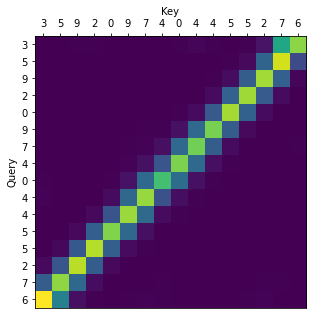

In [9]:
x=model.positional_encoding((model.embedding(inputs)))
out, w=model.transformer.layers[0].self_attn(x, x, x, need_weights=True)

fig, ax = plt.subplots(figsize=(5,5))
i = 0 # plot the i'th attn weight in the batch
ax.imshow(w.data.get()[i])
ax.xaxis.tick_top()
inpt = inputs[i]
ax.set_xticks(list(range(len(inpt))))
ax.set_xticklabels([str(_) for _ in inpt.data.get()])
ax.set_yticks(list(range(len(inpt))))
ax.set_yticklabels([str(_) for _ in inpt.data.get()])
ax.set_xlabel('Key')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Query')
plt.show()

### output
the brightest spot of each row is the output. The input is correctly reversed.

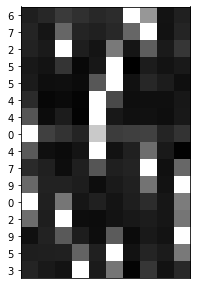

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(outputs.data.get()[i], cmap='gray')
ax.set_xticks([])
ax.set_yticks(list(range(len(labels[i]))))
ax.set_yticklabels([str(_) for _ in labels[i].data.get()])
plt.show()